# DS3000 Project: Twitter and the Stock Market
### Ben Aronow, Nick Haugen, Ben Inglesby, and Aidan Niceberg

In [1]:
import numpy as np
import pandas as pd
from datetime import date, datetime
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

## Using the Polygon API to analyze stock information

### Step 1: Set-up the Polygon API

In [2]:
# The Polygon Api Client library must first be installed in the virtual environment before it is used
!pip install polygon-api-client

In [3]:
# After the library is installed, we can import the RESTClient and other important module packages
from polygon.rest import RESTClient
from typing import cast, Any, Optional
from urllib3 import HTTPResponse
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

In [4]:
# Polygon API Key
api_key = '575m3QbfEdg7S0spB39rx3uHh1TXGw18'

In [5]:
# The Polygon Client is authorized using our Polygon API Key
client = RESTClient(api_key)

### Step 2: Collect Data using the Polygon Client

In [6]:
# A list of stock tickers for which we would like to analyze the performance
stock_tickers = ['AAPL', 'MSFT', 'GOOG', 'DELL', 'AMZN']

In [7]:
# The parameters for the API call to get stock information
timespan = 'day' # The type of timespan over which to analyze stock information
multiplier = 1 # The number of the given timespans analyzed at once
start_date = '2022-01-01' # The date on which to begin the analysis (January 1st, 2022)
end_date = '2022-11-30' # The date on which to end the analysis (November 30th, 2022)
limit = 230 # The number of days to get the performance for

In [8]:
# An empty list in which to store the information for each stock that is analyzed
stock_info_list = []

# Uses the Polygon API to analyze each stock in the list of stock tickers defined above and
# adds to the list of stock information
for stock in stock_tickers:
    stock_info = client.get_aggs(stock,
                                 timespan=timespan,
                                 multiplier=multiplier,
                                 from_=start_date,
                                 to=end_date,
                                 limit=limit)
    
    stock_info_list.append(stock_info)

In [9]:
# An empty list in which to store DataFrames containing curated data for each stock that has been analyzed
stock_data_list = []

# Uses information about each stock to create a new Dataframe containing better metrics
# by which to measure performance and adds to the list of curated data
for n in np.arange(5):
    stock_data = pd.DataFrame(stock_info_list[n])
    stock_data['Date'] = pd.to_datetime(stock_data['timestamp'], unit='ms').dt.date
    
    # Calculates the "performance," or how much the stock price increased/decreased over a given day
    stock_data['Performance'] = stock_data['close'] - stock_data['open']
    
    # Calculates the "range," or the difference between the highest and lowest stock prices of a given day
    stock_data['Range'] = stock_data['high'] - stock_data['low']
    
    # Gets rid of everything in the DataFrame except for the date, performance, and range
    stock_data = stock_data[['Date', 'Performance', 'Range']]
    
    stock_data_list.append(stock_data)

In [10]:
# Weighs the performance and range based on the data from the entire column
for stock_data in stock_data_list:
    stock_data['Weighted Performance'] = stock_data['Performance']
    
    # Alters each performance number such that the lowest number will be zero
    min_performance = stock_data['Weighted Performance'].min()
    stock_data['Weighted Performance'] = stock_data['Weighted Performance'] - min_performance
    
    # Divides each performance number by the maximum performance number in the column so that
    # each performance number will be between zero and one, with the current maximum number set to equal one
    max_performance = stock_data['Weighted Performance'].max()
    stock_data['Weighted Performance'] = stock_data['Weighted Performance'] / max_performance
    
    stock_data['Weighted Range'] = stock_data['Range']
    
    # Alters each range number such that the lowest number will be zero
    min_range = stock_data['Weighted Range'].min()
    stock_data['Weighted Range'] = stock_data['Weighted Range'] - min_range
    
    # Divides each range number by the maximum range number in the column so that
    # each range number will be between zero and one, with the current maximum number set to equal one
    max_range = stock_data['Weighted Range'].max()
    stock_data['Weighted Range'] = stock_data['Weighted Range'] / max_range

In [11]:
# An empty list in which to store DataFrames containing activity metrics for each stock that has been analyzed
stock_data_activity_list = []

# Calculates an activity number and label for every day that each stock was analyzed and and adds to
# the list of activity metrics
for stock_data in stock_data_list:
    # Adds the weighted performance and range metrics together
    stock_data['Activity'] = stock_data['Weighted Performance'] + stock_data['Weighted Range']
    
    # Alters each number such that the lowest number will be zero
    min_activity = stock_data['Activity'].min()
    stock_data['Activity'] = stock_data['Activity'] - min_activity
    
    # Divides each number by the maximum number in the column so that
    # each number will be between zero and one, with the current maximum number set to equal one
    max_activity = stock_data['Activity'].max()
    stock_data['Activity'] = stock_data['Activity'] / max_activity
    
    # Creates a new DataFrame containing only the activity information for each stock and appends it to
    # the list of activity metrics
    stock_data_activity = stock_data[['Date', 'Activity']]
    stock_data_activity_list.append(stock_data_activity)

## Using the Twitter API with Tweepy to analyze tweets

### Step 1: Set-up the Twitter API

In [12]:
# Import the Tweepy library
import tweepy

In [13]:
# Twitter API Keys
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAF8PiwEAAAAACHFZCsxUJ0sp9AUsm30OMkkurC4%3D63IAMcH5jMABS5RdEb2be2jFdXOMR7a7W8evKvHRzMg06X5tuA'
consumer_key = 'FMquV6Q8hly9c3NFEY67dgxhQ'
consumer_secret = 'OfSwD6mUPF5S0V1wLKBgLYmQhxMSiOz80lCZLNfj7en129otdC'
access_token = '1401763487236247552-z4TaOqE268wUwOauHux3Gf4ehcrrMj'
access_token_secret = '5btKI93faVQngwNgtEEzDY1s6MuKaIBcp5RYiUri6xtGX'

In [14]:
# Access to the Twitter API is authorized using our API Keys
auth = tweepy.OAuth1UserHandler(
    consumer_key,
    consumer_secret,
    access_token,
    access_token_secret
)

api = tweepy.API(auth)

In [15]:
# Access to the Tweepy Client is authorized using our API Keys
client = tweepy.Client(bearer_token=bearer_token,
                       consumer_key=consumer_key,
                       consumer_secret=consumer_secret,
                       access_token=access_token,
                       access_token_secret=access_token_secret,
                       wait_on_rate_limit=True)

### Step 2: Collect Data using the Tweepy Client

In [16]:
# A list of CEO's twitter usernames corresponding to the list of stock tickers of which they are the
# respective CEOs
ceo_usernames = ['tim_cook', 'satyanadella', 'sundarpichai', 'MichaelDell', 'JeffBezos']

In [17]:
# The parameters for the API call to get tweet information
start_date='2022-01-01T00:00:00Z' # The date on which to begin the analysis (January 1st, 2022)
end_date='2022-11-30T11:59:59Z' # The date on which to end the analysis (November 30th, 2022)
limit = 200 # The number of tweets to get the information for

In [18]:
# An empty list in which to store DataFrames containing tweet data for each user that is analyzed
tweet_data_list = []

# Creates a DataFrame containing information for each tweet in a user's timeline over the given time range,
# consisting of the date as well as the number of likes, retweets, and quote tweets that it received
for n in np.arange(5):
    # Gets the user id of the user from their username
    username = ceo_usernames[n]
    status = api.get_user(screen_name=username)
    user_id = status.id
    
    # Uses the Twitter API to collect tweets from the user's timeline over the given time range, excluding
    # both retweets and replies from the search while collecting data for the creation date and metrics of
    # each tweet
    tweets = tweepy.Paginator(client.get_users_tweets,
                              user_id,
                              exclude='retweets,replies',
                              end_time=end_date,
                              start_time=start_date,
                              tweet_fields=['created_at', 'public_metrics']).flatten(limit=limit)
    
    # An empty list in which to store the data collected on each tweet to create a DataFrame for each user
    data = []
    # The columns for the DataFrame to which the list of data will be added
    columns = ['Date', 'Tweets', 'Likes', 'Retweets', 'Quote Tweets']
    
    # Adds the information for each tweet to the list of data
    for tweet in tweets:
        data.append([tweet.created_at, 1,
                     tweet.public_metrics['like_count'],
                     tweet.public_metrics['retweet_count'],
                     tweet.public_metrics['quote_count']])
    
    # Creates a DataFrame with the date, likes, retweets, quote tweets for each tweet, and includes a tweet
    # category with a 1 to signify that a tweet occurred for when the data is joined with that of the stock
    # performance. This DataFrame is then appended to the list of DataFrames
    tweet_data = pd.DataFrame(data, columns=columns)
    tweet_data['Date'] = pd.to_datetime(tweet_data['Date']).dt.date
    tweet_data_list.append(tweet_data)

## Joining the Stock and Tweet data

In [19]:
# An empty list to store the DataFrames containing data for both the stock activity and tweet information on each
# day in the given time range
stock_tweet_data_list = []

# Merges each corresponding stock and tweet DataFrame such that for each day in the given time range, the stock
# activity and activity level, as well as if a tweet occured that day, and how many likes, retweets, and quote
# tweets it recieved
for n in np.arange(5):
    stock_tweet_data = pd.merge(stock_data_activity_list[n], tweet_data_list[n], on='Date', how='left')
    # All of the null values for tuples represnting days on which a tweet did not occur are filled with zeros
    # to signify that no tweets, likes, retweets, or quote tweets happened on that day
    stock_tweet_data['Tweets'] = stock_tweet_data['Tweets'].fillna(0)
    stock_tweet_data['Likes'] = stock_tweet_data['Likes'].fillna(0)
    stock_tweet_data['Retweets'] = stock_tweet_data['Retweets'].fillna(0)
    stock_tweet_data['Quote Tweets'] = stock_tweet_data['Quote Tweets'].fillna(0)
    
    # Appends the new merged DataFrame to the list
    stock_tweet_data_list.append(stock_tweet_data)
    
# Creates a final DataFrame containing all information for each stock/tweet pairing by concatenating all of the
# DataFrames for each individual pairing
full_data = pd.concat([stock_tweet_data_list[0],
                       stock_tweet_data_list[1],
                       stock_tweet_data_list[2],
                       stock_tweet_data_list[3],
                       stock_tweet_data_list[4]])

## Training a Random Forest Regressor model

### Step 1: Build the model and predict target labels

In [20]:
# Set the input features and the target label to train the Random Forest Regressor model with
X_randomforest = full_data[['Tweets', 'Likes', 'Retweets', 'Quote Tweets']]
y_randomforest = full_data['Activity']

# Partition the data into training and testing sets
X_randomforest_train, X_randomforest_test, y_randomforest_train, y_randomforest_test = train_test_split(
    X_randomforest, # The input features
    y_randomforest, # The target label
    test_size=0.3,  # Sets aside 30% of the data as the test set
    random_state=7, # Allows the results to be reproducible
)

In [21]:
# Build the Random Forest Regressor model and fit the training data to it
rf = RandomForestRegressor(random_state=7)
rf.fit(X_randomforest_train, y_randomforest_train)

RandomForestRegressor(random_state=7)

In [22]:
# Predict the target labels for the test set
y_randomforest_pred = rf.predict(X_randomforest_test)
print('The predicted activity is: {}'.format(y_randomforest_pred))

The predicted activity is: [0.19551154 0.19551154 0.19134985 0.19551154 0.19551154 0.19551154
 0.11899181 0.19551154 0.19551154 0.19551154 0.27307627 0.15367855
 0.19551154 0.19551154 0.15298482 0.19204517 0.19551154 0.19551154
 0.19551154 0.19551154 0.19551154 0.19551154 0.16812305 0.19551154
 0.19551154 0.19551154 0.19551154 0.169968   0.19056611 0.19551154
 0.24215936 0.29859592 0.35661765 0.13004073 0.19551154 0.19551154
 0.12899234 0.22104366 0.19551154 0.09752408 0.19551154 0.19551154
 0.14926146 0.19551154 0.19551154 0.19551154 0.35975954 0.19551154
 0.19551154 0.19551154 0.28507199 0.2307565  0.19551154 0.19551154
 0.19551154 0.19551154 0.19551154 0.19551154 0.19551154 0.15308759
 0.19551154 0.10210863 0.23076309 0.19551154 0.14526141 0.19551154
 0.19551154 0.19551154 0.19551154 0.19551154 0.19551154 0.19551154
 0.30625739 0.19551154 0.19551154 0.28040481 0.16629313 0.19551154
 0.19078509 0.19551154 0.24539781 0.19551154 0.19551154 0.19551154
 0.19551154 0.24132283 0.19551154 0

In [23]:
# Calculate the mean squared error from the predicted target labels to evaluate the predictions
mse = mean_squared_error(y_randomforest_test, y_randomforest_pred)
print('The mse of the model is: {}'.format(mse))

The mse of the model is: 0.02196980016649896


### Step 2: Tweak the model

In [24]:
# An empty dictionary in which to put estimator values and their corresponding
# mean squared error
predictions = {}

# Identifies a suitable value of estimators by testing the Random Forest Regressor model
# with 85 to 115 n_estimators
for n in np.arange(85, 115):
    n_rf = RandomForestRegressor(n_estimators=n, max_depth=n, random_state=7)
    n_rf.fit(X_randomforest_train, y_randomforest_train)
    n_y_randomforest_pred = n_rf.predict(X_randomforest_test)
    predictions[n] = mean_squared_error(y_randomforest_test, n_y_randomforest_pred)

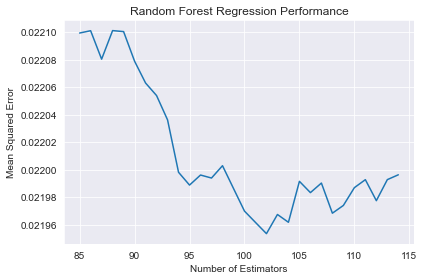

In [25]:
# Visualizes the predictions by plotting the estimator and mean squared error values
sns.lineplot(x=predictions.keys(), y=predictions.values())
plt.title('Random Forest Regression Performance')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')
plt.tight_layout()
plt.show()

In [26]:
# Displays the lowest mean squared error obtained by the model
lowest_value = min(predictions.values())
lowest_position = 85 + list(predictions.values()).index(lowest_value)

print('The most accurate number of estimators is: {}'.format(lowest_position))
print('The smallest mean squared error is: {}'.format(lowest_value))

The most accurate number of estimators is: 102
The smallest mean squared error is: 0.02195340498281133


## Training a Support Vector Machine Regression model

### Step 1: Build the model and predict target labels

In [27]:
# Set the input features and the target label to train the Support Vector Machine Regression model with
X_supportvector = full_data[['Tweets', 'Likes', 'Retweets', 'Quote Tweets']]
y_supportvector = full_data['Activity']

# Partition the data into training and testing sets
X_supportvector_train, X_supportvector_test, y_supportvector_train, y_supportvector_test = train_test_split(
    X_supportvector, # The input features
    y_supportvector, # The target label
    test_size=0.3,  # Sets aside 30% of the data as the test set
    random_state=7, # Allows the results to be reproducible
)

In [28]:
# Create copies of the input feature training and testing data
X_supportvector_train = X_supportvector_train.copy()
X_supportvector_test  = X_supportvector_test.copy()

In [29]:
# Normalize the numeric features
scaler = StandardScaler()
scaler.fit(X_supportvector_train[['Tweets', 'Likes', 'Retweets', 'Quote Tweets']])

X_supportvector_train[['Tweets', 'Likes', 'Retweets', 'Quote Tweets']] = scaler.transform(
    X_supportvector_train[['Tweets', 'Likes', 'Retweets', 'Quote Tweets']]) #scale the training data

In [30]:
# Build the Support Vector Machine Regression model and fit the training data to it
svm = SVR()
svm.fit(X_randomforest_train, y_randomforest_train)

SVR()

In [31]:
# Sscale the test data
X_supportvector_test[['Tweets', 'Likes', 'Retweets', 'Quote Tweets']] = scaler.transform(
    X_supportvector_test[['Tweets', 'Likes', 'Retweets', 'Quote Tweets']])

# Predict the target labels for the test data
y_supportvector_pred = svm.predict(X_supportvector_test)
print('The predicted BMI is: {}'.format(y_supportvector_pred))

The predicted BMI is: [0.18562419 0.18562419 0.18562253 0.18562419 0.18562419 0.18562419
 0.18561038 0.18562419 0.18562419 0.18562419 0.18562146 0.18561776
 0.18562419 0.18562419 0.1856237  0.1856072  0.18562419 0.18562419
 0.18562419 0.18562419 0.18562419 0.18562419 0.18561054 0.18562419
 0.18562419 0.18562419 0.18562419 0.18562348 0.18562411 0.18562419
 0.18561819 0.18562409 0.18562413 0.1855837  0.18562419 0.18562419
 0.18562276 0.1856238  0.18562419 0.18562361 0.18562419 0.18562419
 0.18561672 0.18562419 0.18562419 0.18562419 0.18562364 0.18562419
 0.18562419 0.18562419 0.18562404 0.18562345 0.18562419 0.18562419
 0.18562419 0.18562419 0.18562419 0.18562419 0.18562419 0.18562414
 0.18562419 0.18562306 0.1856239  0.18562419 0.18562398 0.18562419
 0.18562419 0.18562419 0.18562419 0.18562419 0.18562419 0.18562419
 0.18562199 0.18562419 0.18562419 0.1856241  0.1856233  0.18562419
 0.18562402 0.18562419 0.18562329 0.18562419 0.18562419 0.18562419
 0.18562419 0.18562373 0.18562419 0.1856

In [32]:
# Calculate the mean squared error from the predicted target labels to evaluate the predictions
mse = mean_squared_error(y_supportvector_test, y_supportvector_pred)
print('The mse of the model is: {}'.format(mse))

The mse of the model is: 0.019258408671438073


### Step 2: Tune the hyperparameters

In [33]:
# Setup the parameter grid to try values of C ranging from 1 to 10, all values
# for kernel besides precomputed, and values of degree from ranging from 1 to 10
params = {'C': np.arange(1, 10),
          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'degree': np.arange(1, 5)}

svm = SVR()

In [34]:
# Initialize grid search with cross validation and also return the training score
svm_grid = GridSearchCV(estimator = svm, param_grid = params, cv=5, return_train_score = True) 
svm_grid.fit(X_supportvector_train, y_supportvector_train)

{'C': 1, 'degree': 1, 'kernel': 'poly'}
-0.016091979113648014


In [35]:
# Display the best parameters and the best score
print('The most accurate parameters were: {}'.format(svm_grid.best_params_))
print('The lowest mean squared error was: {}'.format(-svm_grid.best_score_))

The most accurate parameters were: {'C': 1, 'degree': 1, 'kernel': 'poly'}
The lowest mean squared error was: 0.016091979113648014


## Training a Linear Regression model

### Step 1: Build the model and predict target labels

In [36]:
# Set the input features and the target label to train the Linear Regression model with
X_lreg = full_data[['Tweets', 'Likes', 'Retweets', 'Quote Tweets']]
y_lreg = full_data['Activity']

# Partition the data into training and testing sets
X_lreg_train, X_lreg_test, y_lreg_train, y_lreg_test = train_test_split(
    X_lreg, # The input features
    y_lreg, # The target label
    test_size=0.3,  # Sets aside 30% of the data as the test set
    random_state=7, # Allows the results to be reproducible
)

In [37]:
# Build the Linear Regression model and fit the training data to it
lreg = LinearRegression()
lreg.fit(X_lreg_train, y_lreg_train)

LinearRegression()

In [38]:
# Predict the target labels for the test set
y_lreg_pred = lreg.predict(X_randomforest_test)
print('The predicted activity is: {}'.format(y_lreg_pred))

The predicted activity is: [0.19568783 0.19568783 0.20162386 0.19568783 0.19568783 0.19568783
 0.19508534 0.19568783 0.19568783 0.19568783 0.20187878 0.19656497
 0.19568783 0.19568783 0.2015011  0.20215975 0.19568783 0.19568783
 0.19568783 0.19568783 0.19568783 0.19568783 0.18602647 0.19568783
 0.19568783 0.19568783 0.19568783 0.19983381 0.20156085 0.19568783
 0.20328435 0.20151569 0.20160743 0.18179045 0.19568783 0.19568783
 0.20196578 0.201548   0.19568783 0.20135474 0.19568783 0.19568783
 0.197227   0.19568783 0.19568783 0.19568783 0.2011515  0.19568783
 0.19568783 0.19568783 0.20120635 0.20126039 0.19568783 0.19568783
 0.19568783 0.19568783 0.19568783 0.19568783 0.19568783 0.20159597
 0.19568783 0.2007676  0.20156289 0.19568783 0.2014792  0.19568783
 0.19568783 0.19568783 0.19568783 0.19568783 0.19568783 0.19568783
 0.20228871 0.19568783 0.19568783 0.20154393 0.20167375 0.19568783
 0.20161424 0.19568783 0.20094021 0.19568783 0.19568783 0.19568783
 0.19568783 0.20148364 0.19568783 0

In [39]:
# Calculate the mean squared error from the predicted target labels to evaluate the predictions
mse = mean_squared_error(y_lreg_test, y_lreg_pred)
print('The mse of the model is: {}'.format(mse))

The mse of the model is: 0.01951185285435527
